In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns

In [2]:
print(os.listdir("X-Ray"))

['Bacterial', 'test', 'train', 'validation', 'Viral']


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

CATEGORIES = ["Bacterial", "Viral"]
DATADIR = 'X-Ray'

image_size = 100

for klasor in CATEGORIES:
    klasor_path = os.path.join(DATADIR, klasor)
    train_path = os.path.join(DATADIR, 'train', klasor)
    validation_path = os.path.join(DATADIR, 'validation',klasor)
    test_path = os.path.join(DATADIR, 'test', klasor)

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(validation_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    resimler = [dosya for dosya in os.listdir(klasor_path) if dosya.endswith('.jpg')]

    train_resimler, test_resimler = train_test_split(resimler, test_size=0.35, random_state=42)

    train_resimler, validation_resimler = train_test_split(train_resimler, test_size=0.1, random_state=42)

    for resim in train_resimler:
        source_path = os.path.join(klasor_path, resim)
        target_path = os.path.join(train_path, resim)
        shutil.copy(source_path, target_path)

    for resim in validation_resimler:
        source_path = os.path.join(klasor_path, resim)
        target_path = os.path.join(validation_path, resim)
        shutil.copy(source_path, target_path)

    for resim in test_resimler:
        source_path = os.path.join(klasor_path, resim)
        target_path = os.path.join(test_path, resim)
        shutil.copy(source_path, target_path)

In [4]:
IMG_SIZE = 100

In [5]:
all_data =[]

def create_all_data():
    for category in CATEGORIES:
        print(category)
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                all_data.append([new_array,class_num])
            except Exception as e:
                pass
create_all_data()

Bacterial
Viral


In [6]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  3592


In [7]:

X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [10]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(2100, 100, 100, 3)
(1258, 100, 100, 3)
(234, 100, 100, 3)
(2100,)
(1258,)
(234,)


In [11]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=2)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=2)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [12]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from kerastuner.tuners import RandomSearch

# Model fonksiyonunu tanımla
def build_model(hp):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Hiperparametreler
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    return model

# Tuner'ı tanımla
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Farklı hiperparametre kombinasyonları sayısı
    directory='my_dir',  # Tuner'ın sonuçlarını saklamak için bir dizin
    project_name='my_project'
)

# Modeli eğitim verileri üzerinde eğitme
tuner.search(x_train, train_yCl,
             epochs=5,
             batch_size=256,
             validation_data=(x_val, valid_yCl),
             callbacks=[ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True),
                        EarlyStopping(monitor="val_loss", patience=10)])

# En iyi hiperparametreleri al
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# En iyi modeli oluştur
best_model = tuner.hypermodel.build(best_hps)

# Modeli eğit
best_model.fit(x_train, train_yCl,
               epochs=5,
               batch_size=256,
               validation_data=(x_val, valid_yCl),
               callbacks=[ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True),
                          EarlyStopping(monitor="val_loss", patience=10)])

# Model değerlendirme
score_valid = best_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = best_model.evaluate(x_test, test_yCl)
print("Test Accuracy: ", score_test[1])

score_train = best_model.evaluate(x_train, train_yCl)
print("Train Accuracy: ", score_train[1])


<ipython-input-12-f50e9e4db4cf>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from my_dir\my_project\tuner0.json


Epoch 1/5


9/9 [==============================] - ETA: 0s - loss: 4.6428 - accuracy: 0.5529 

c:\users\excalibur\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 114s 12s/step - loss: 4.6428 - accuracy: 0.5529 - val_loss: 139.8224 - val_accuracy: 0.6068
Epoch 2/5
9/9 [==============================] - 115s 13s/step - loss: 0.9861 - accuracy: 0.6071 - val_loss: 162.7083 - val_accuracy: 0.6068
Epoch 3/5
9/9 [==============================] - 115s 13s/step - loss: 0.8612 - accuracy: 0.6333 - val_loss: 128.4598 - val_accuracy: 0.6068
Epoch 4/5
9/9 [==============================] - 116s 13s/step - loss: 0.7308 - accuracy: 0.6867 - val_loss: 73.9754 - val_accuracy: 0.6068
Epoch 5/5
8/8 [==============================] - 3s 352ms/step - loss: 51.7070 - accuracy: 0.6068
Validation Accuracy:  0.6068376302719116
40/40 [==============================] - 15s 381ms/step - loss: 51.1936 - accuracy: 0.6200
Test Accuracy:  0.6200317740440369
66/66 [==============================] - 26s 390ms/step - loss: 52.0162 - accuracy: 0.6138
Train Accuracy:  0.6138095259666443


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred_prob = best_model.predict(x_test)  # Assuming best_model is the model you want to evaluate
y_pred = np.argmax(y_pred_prob, axis=1)

# Accuracy
accuracy = accuracy_score(np.argmax(test_yCl, axis=1), y_pred)  # Assuming test_yCl is the true labels for the test set
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Precision
precision = precision_score(np.argmax(test_yCl, axis=1), y_pred, average='weighted')  # Use 'weighted' for multi-class
print("Precision: {:.2f}".format(precision))

# Recall
recall = recall_score(np.argmax(test_yCl, axis=1), y_pred, average='weighted')  # Use 'weighted' for multi-class
print("Recall: {:.2f}".format(recall))

# F1 Score
f1 = f1_score(np.argmax(test_yCl, axis=1), y_pred, average='weighted')  # Use 'weighted' for multi-class
print("F1 Score: {:.2f}".format(f1))

# Karmaşıklık Matrisi
conf_mat = confusion_matrix(np.argmax(test_yCl, axis=1), y_pred)
print("Confusion Matrix:\n", conf_mat)

# Classification Report
class_report = classification_report(np.argmax(test_yCl, axis=1), y_pred, target_names=CATEGORIES)
print("Classification Report:\n", class_report)

40/40 [==============================] - 16s 385ms/step
Accuracy: 62.00%
Precision: 0.38
Recall: 0.62
F1 Score: 0.47
Confusion Matrix:
 [[780   0]
 [478   0]]
Classification Report:
               precision    recall  f1-score   support

   Bacterial       0.62      1.00      0.77       780
       Viral       0.00      0.00      0.00       478

    accuracy                           0.62      1258
   macro avg       0.31      0.50      0.38      1258
weighted avg       0.38      0.62      0.47      1258



c:\users\excalibur\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\excalibur\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\excalibur\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 0.9927 - accuracy: 0.5319 

c:\users\excalibur\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 210s 23s/step - loss: 0.9927 - accuracy: 0.5319 - val_loss: 28782.4746 - val_accuracy: 0.3932
Epoch 2/5
9/9 [==============================] - 206s 22s/step - loss: 0.7804 - accuracy: 0.5771 - val_loss: 25.6392 - val_accuracy: 0.3932
Epoch 3/5
9/9 [==============================] - 205s 23s/step - loss: 0.7720 - accuracy: 0.6086 - val_loss: 889.2433 - val_accuracy: 0.4103
Epoch 4/5
9/9 [==============================] - 217s 23s/step - loss: 0.7363 - accuracy: 0.6224 - val_loss: 9.6870 - val_accuracy: 0.3932
Epoch 5/5
9/9 [==============================] - 192s 21s/step - loss: 0.7405 - accuracy: 0.6381 - val_loss: 2.9315 - val_accuracy: 0.3974


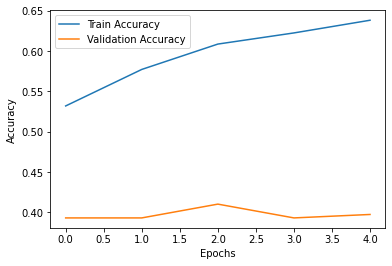

40/40 [==============================] - 29s 716ms/step - loss: 2.9318 - accuracy: 0.3792
Transfer Learning Test Accuracy: 37.92%


In [14]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# VGG16 modelini kullanarak yeni bir model oluşturun
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = Sequential()

# Önceden eğitilmiş VGG16 modelini ekleyin
model.add(base_model)

# Flatten layer ekleyin
model.add(Flatten())

# Tamamen bağlı katman ekleyin
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Sınıf sayısı kadar çıkış katmanı ekleyin
model.add(Dense(2, activation='softmax'))

# Modeli derleme
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitim verileri üzerinde eğitme
history = model.fit(x_train, train_yCl,
                    epochs=5,
                    batch_size=256,
                    validation_data=(x_val, valid_yCl),
                    callbacks=[ModelCheckpoint("best_transfer_learning_model.h5", monitor="val_loss", save_best_only=True),
                               EarlyStopping(monitor="val_loss", patience=3)],
                    verbose=1)

# Eğitim sonuçlarını görselleştirme (isteğe bağlı)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Transfer learning modelinin test doğruluğunu değerlendirme
score_transfer_learning = model.evaluate(x_test, test_yCl)
print("Transfer Learning Test Accuracy: {:.2f}%".format(score_transfer_learning[1] * 100))


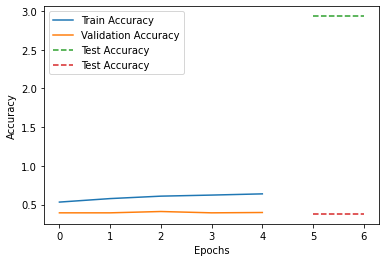

In [15]:
# Test doğruluğunu görselleştirme
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot([len(history.history['accuracy']) + i for i in range(len(score_transfer_learning))], [score_transfer_learning] * len(score_transfer_learning), label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Modelin tahminlerini alın
# Modelin tahminlerini alın
y_pred_transfer_learning_prob = model.predict(x_test)
y_pred_transfer_learning = np.argmax(y_pred_transfer_learning_prob, axis=1)


# One-hot encoding'i geri dönüştür
y_true_transfer_learning = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy_transfer_learning = accuracy_score(y_true_transfer_learning, y_pred_transfer_learning)
print("Transfer Learning Test Accuracy: {:.2f}%".format(accuracy_transfer_learning * 100))

# Precision
precision_transfer_learning = precision_score(y_true_transfer_learning, y_pred_transfer_learning)
print("Transfer Learning Precision: {:.2f}".format(precision_transfer_learning))

# Recall
recall_transfer_learning = recall_score(y_true_transfer_learning, y_pred_transfer_learning)
print("Transfer Learning Recall: {:.2f}".format(recall_transfer_learning))

# F1 Score
f1_transfer_learning = f1_score(y_true_transfer_learning, y_pred_transfer_learning)
print("Transfer Learning F1 Score: {:.2f}".format(f1_transfer_learning))

# Karmaşıklık Matrisi
conf_mat_transfer_learning = confusion_matrix(y_true_transfer_learning, y_pred_transfer_learning)
print("Transfer Learning Confusion Matrix:\n", conf_mat_transfer_learning)

# Classification Report
class_report_transfer_learning = classification_report(y_true_transfer_learning, y_pred_transfer_learning, target_names=CATEGORIES)
print("Transfer Learning Classification Report:\n", class_report_transfer_learning)


40/40 [==============================] - 29s 720ms/step
Transfer Learning Test Accuracy: 37.92%
Transfer Learning Precision: 0.38
Transfer Learning Recall: 1.00
Transfer Learning F1 Score: 0.55
Transfer Learning Confusion Matrix:
 [[  0 780]
 [  1 477]]
Transfer Learning Classification Report:
               precision    recall  f1-score   support

   Bacterial       0.00      0.00      0.00       780
       Viral       0.38      1.00      0.55       478

    accuracy                           0.38      1258
   macro avg       0.19      0.50      0.27      1258
weighted avg       0.14      0.38      0.21      1258



In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Yapay Sinir Ağı Modeli
model_custom = Sequential()

model_custom.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))
model_custom.add(BatchNormalization())
model_custom.add(Dropout(0.25))

model_custom.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))
model_custom.add(BatchNormalization())
model_custom.add(Dropout(0.25))

model_custom.add(Flatten())
model_custom.add(Dense(512, activation='relu'))
model_custom.add(BatchNormalization())
model_custom.add(Dropout(0.5))

model_custom.add(Dense(2, activation='softmax'))


In [18]:
# Modeli derleme
model_custom.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Modeli eğitme
history_custom = model_custom.fit(x_train, train_yCl,
                                  epochs=5,
                                  batch_size=512,
                                  validation_data=(x_val, valid_yCl),
                                  callbacks=[ModelCheckpoint("best_custom_model.h5", monitor="val_loss", save_best_only=True),
                                             EarlyStopping(monitor="val_loss", patience=3)],
                                  verbose=1)

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 3.3210 - accuracy: 0.6152

c:\users\excalibur\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 13s 2s/step - loss: 3.3210 - accuracy: 0.6152 - val_loss: 138.0178 - val_accuracy: 0.3932
Epoch 2/5
5/5 [==============================] - 12s 2s/step - loss: 0.9195 - accuracy: 0.7133 - val_loss: 15.7129 - val_accuracy: 0.4188
Epoch 3/5
5/5 [==============================] - 11s 2s/step - loss: 0.7138 - accuracy: 0.7081 - val_loss: 7.1773 - val_accuracy: 0.4530
Epoch 4/5
5/5 [==============================] - 11s 2s/step - loss: 0.6489 - accuracy: 0.7305 - val_loss: 8.6428 - val_accuracy: 0.4231
Epoch 5/5
5/5 [==============================] - 11s 2s/step - loss: 0.5745 - accuracy: 0.7410 - val_loss: 7.3737 - val_accuracy: 0.4573


In [20]:
# Test verisi üzerinde modelin performansını değerlendirme
y_pred_custom_prob = model_custom.predict(x_test)
y_pred_custom = np.argmax(y_pred_custom_prob, axis=1)

# One-hot encoding'i geri dönüştür
y_true_custom = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy_custom = accuracy_score(y_true_custom, y_pred_custom)
print("Custom Model Test Accuracy: {:.2f}%".format(accuracy_custom * 100))

# Precision
precision_custom = precision_score(y_true_custom, y_pred_custom)
print("Custom Model Precision: {:.2f}".format(precision_custom))

# Recall
recall_custom = recall_score(y_true_custom, y_pred_custom)
print("Custom Model Recall: {:.2f}".format(recall_custom))

# F1 Score
f1_custom = f1_score(y_true_custom, y_pred_custom)
print("Custom Model F1 Score: {:.2f}".format(f1_custom))

# Karmaşıklık Matrisi
conf_mat_custom = confusion_matrix(y_true_custom, y_pred_custom)
print("Custom Model Confusion Matrix:\n", conf_mat_custom)

# Classification Report
class_report_custom = classification_report(y_true_custom, y_pred_custom, target_names=CATEGORIES)
print("Custom Model Classification Report:\n", class_report_custom)

40/40 [==============================] - 2s 37ms/step
Custom Model Test Accuracy: 44.04%
Custom Model Precision: 0.40
Custom Model Recall: 0.97
Custom Model F1 Score: 0.57
Custom Model Confusion Matrix:
 [[ 91 689]
 [ 15 463]]
Custom Model Classification Report:
               precision    recall  f1-score   support

   Bacterial       0.86      0.12      0.21       780
       Viral       0.40      0.97      0.57       478

    accuracy                           0.44      1258
   macro avg       0.63      0.54      0.39      1258
weighted avg       0.69      0.44      0.34      1258

